In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [2]:
import wandb
wandb.init(project='house-price-prediction', entity='luna_4444')

wandb: Currently logged in as: luna_4444 (use `wandb login --relogin` to force relogin)


In [3]:
df_train = pd.read_csv('train.csv')
df_train.set_index(keys='Id', inplace=True)

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

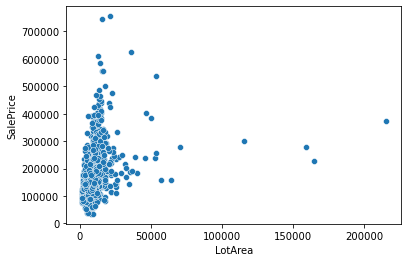

In [6]:
sns.scatterplot(x = df_train['LotArea'], y = df_train['SalePrice'], cmap='blues')

In [7]:
df_train['LotArea'].sort_values(ascending=False)[:4]

Id
314    215245
336    164660
250    159000
707    115149
Name: LotArea, dtype: int64

In [4]:
df_train.drop([314, 336, 250, 707], axis=0, inplace = True)

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

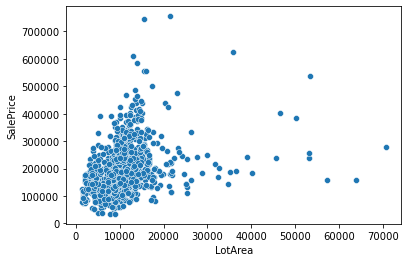

In [9]:
sns.scatterplot(x = df_train['LotArea'], y = df_train['SalePrice'], cmap='blues')

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

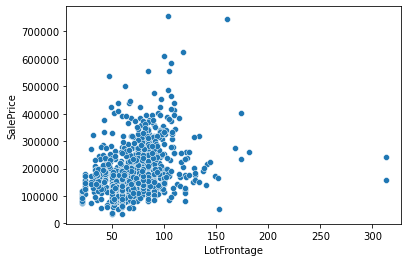

In [10]:
sns.scatterplot(x = df_train['LotFrontage'], y = df_train['SalePrice'], cmap='blues')

In [11]:
df_train['LotFrontage'].sort_values(ascending=False)[:2]

Id
1299    313.0
935     313.0
Name: LotFrontage, dtype: float64

In [5]:
df_train.drop(1299, axis=0, inplace=True)
df_train.drop(935, axis=0, inplace=True)

In [6]:
df_test = pd.read_csv('test.csv')
df_test.set_index(keys='Id', inplace=True)

In [7]:
target = df_train['SalePrice']
df_train.drop(['SalePrice'], axis=1, inplace=True)

In [8]:
complete = pd.concat([df_train, df_test])

In [9]:
plt.figure(figsize=(25, 10))
px.imshow(complete.isna())

<Figure size 1800x720 with 0 Axes>

In [10]:
# Fill MSZoning with mode
complete['MSZoning'].fillna(complete['MSZoning'].mode()[0], inplace=True)

# Fill MaxVnrType with mode
complete['MasVnrType'].fillna(complete['MasVnrType'].mode()[0], inplace=True)

# Fill MasVnrArea with mode
complete['MasVnrArea'].fillna(complete['MasVnrArea'].mode()[0], inplace=True)

# Fill LotFrontage with mean
complete['LotFrontage'].fillna(complete['LotFrontage'].mean(), inplace=True)

# Fill BsmFinType2
complete['BsmtFinType2'].fillna(complete['BsmtFinType2'].mode()[0], inplace=True)

complete['BsmtFinType1'].fillna(complete['BsmtFinType1'].mode()[0], inplace=True)

complete['BsmtExposure'].fillna(complete['BsmtExposure'].mode()[0], inplace=True)

complete['BsmtCond'].fillna(complete['BsmtCond'].mode()[0], inplace=True)

complete['BsmtQual'].fillna(complete['BsmtQual'].mode()[0], inplace=True)

In [11]:
complete.dropna(axis=1, inplace=True)

In [12]:
complete = pd.get_dummies(complete)

In [13]:
test = complete.iloc[len(df_train):]

In [14]:
train = complete.iloc[:len(df_train)]

In [15]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler().fit(train)
train = scalar.transform(train)
scalar = StandardScaler().fit(test)
test = scalar.transform(test)

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

In [35]:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

In [36]:
wandb.sklearn.plot_regressor(reg_model, X_train, X_test, y_train, y_test, model_name="Linear Regression")

wandb: 
wandb: Plotting Linear Regression.
wandb: Logged summary metrics.
wandb: Logged learning curve.
/home/luna/anaconda3/lib/python3.8/site-packages/wandb/sklearn/calculate/outlier_candidates.py:28: RuntimeWarning:

invalid value encountered in sqrt

/home/luna/anaconda3/lib/python3.8/site-packages/wandb/sklearn/calculate/outlier_candidates.py:28: RuntimeWarning:

divide by zero encountered in true_divide

/home/luna/anaconda3/lib/python3.8/site-packages/wandb/sklearn/calculate/outlier_candidates.py:30: RuntimeWarning:

divide by zero encountered in true_divide

wandb: WARNING using only the first 1000 datapoints to create chart outlier_candidates
wandb: Logged outlier candidates.
wandb: WARNING using only the first 100 datapoints to create chart residuals
wandb: WARNING using only the first 100 datapoints to create chart residuals
wandb: Logged residuals.


In [118]:
predictions = reg_model.predict(test)

In [37]:
import xgboost
from sklearn.metrics import mean_absolute_error

In [40]:
xg = xgboost.XGBRegressor()
xg.fit(X_train, y_train, callbacks=[wandb.wandb.xgboost.wandb_callback()])
mean_absolute_error(y_test, xg.predict(X_test))
y_pred = xg.predict(X_test)

/home/luna/anaconda3/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



In [44]:
wandb.sklearn.plot_regressor(xg, X_train,X_test, y_train, y_test, model_name='XGBoost')

wandb: 
wandb: Plotting XGBoost.
wandb: Logged summary metrics.
wandb: Logged learning curve.
/home/luna/anaconda3/lib/python3.8/site-packages/wandb/sklearn/calculate/outlier_candidates.py:28: RuntimeWarning:

invalid value encountered in sqrt

/home/luna/anaconda3/lib/python3.8/site-packages/wandb/sklearn/calculate/outlier_candidates.py:28: RuntimeWarning:

divide by zero encountered in true_divide

/home/luna/anaconda3/lib/python3.8/site-packages/wandb/sklearn/calculate/outlier_candidates.py:30: RuntimeWarning:

divide by zero encountered in true_divide

wandb: WARNING using only the first 1000 datapoints to create chart outlier_candidates
wandb: Logged outlier candidates.
wandb: WARNING using only the first 100 datapoints to create chart residuals
wandb: WARNING using only the first 100 datapoints to create chart residuals
wandb: Logged residuals.


In [66]:
import catboost
ctb = catboost.CatBoostRegressor(verbose=False)
ctb.fit(train, target)

In [67]:
predictions = ctb.predict(test)

In [47]:
from sklearn.metrics import mean_absolute_error
import optuna

In [63]:
def objective(trial, train = train, target = target):
    try: 
        X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)
        params ={
            'tree_method': 'gpu_hist',
            'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
            'max_depth': trial.suggest_categorical('max_depth', [1,2,3,4,6,10,14,18]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 10.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
            'base_score': trial.suggest_loguniform('base_score', 0.001, 0.999)
        }

        model = xgboost.XGBRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

        y_pred = model.predict(X_test)

        score = mean_absolute_error(y_test, y_pred)
        return score
    except Exception as e:
        print(e)

In [64]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)
print("Number of trials finished: ", len(study.trials))
print("Best trial: ",study.best_trial.params)

[I 2021-11-12 17:35:50,019] A new study created in memory with name: no-name-8400d005-8314-42ba-a001-94f27b078843
[I 2021-11-12 17:35:58,439] Trial 0 finished with value: 134353.8004725086 and parameters: {'n_estimators': 1116, 'max_depth': 4, 'learning_rate': 0.0002524567365230446, 'min_child_weight': 219, 'base_score': 0.0675633761788994}. Best is trial 0 with value: 134353.8004725086.


Number of trials finished:  1
Best trial:  {'n_estimators': 1116, 'max_depth': 4, 'learning_rate': 0.0002524567365230446, 'min_child_weight': 219, 'base_score': 0.0675633761788994}


In [124]:
from sklearn.model_selection import RandomizedSearchCV

## Hyper Parameter Optimization


n_estimators = [900]
max_depth = [1, 2, 3]
booster=['gbtree']
learning_rate=[0.05,0.10,0.2]
min_child_weight=[1,2,3,4]

base_score=[0.25,0.5,1]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

regressor = xgboost.XGBRegressor(tree_method='gpu_hist', gpu_id=0)

In [125]:
# Set up the random search with 5-fold cross validation
random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = -1,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [126]:
random_cv.fit(train, target)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=0, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=Non...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method='gpu_hist',
                                          va

In [128]:
random_cv.best_params_

{'n_estimators': 900,
 'min_child_weight': 2,
 'max_depth': 2,
 'learning_rate': 0.05,
 'booster': 'gbtree',
 'base_score': 1}

In [138]:
random_xg = xgboost.XGBRegressor(n_estimators=900, min_child_weight=2, max_depth=2, learning_rate=0.05, booster='gbtree', base_score=1)

In [139]:
random_xg.fit(train, target)

XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=2, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=900, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [140]:
random_xg.score(train, target)

0.9654143681799245

In [68]:
predictions = ctb.predict(test)

In [39]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [69]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['SalePrice'] = predictions
sample_submission.to_csv('sample_submission.csv', index=False)

#### Leaderboard
- House Prices Competition for Kaggle Learn Users: 250/27288
- House Prices - Advanced Regression Techniques: 847/4458